# Exploratory Data Analysis

### Import

In [17]:
# Load data
import os, sys
sys.path.append('../src')
sys.path.append('../models')
from load_data import DataGetter

# Models
from language_detector_model import LanguageDetector

# Track time
from tqdm import tqdm

import pandas as pd

# Feature Processing
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualization
from yellowbrick.text import TSNEVisualizer

from sklearn.model_selection import train_test_split

from process_corpus import add_languages, remove_stop_words_corpus, clean_text_corpus, remove_non_english_docs, remove_columns, steam_corpus

[nltk_data] Downloading package punkt to
[nltk_data]     /home/joaosaraceni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Datasets

In [ ]:
data_getter = DataGetter(['actual_set','app_installs','app_metadata',
                          'app_usage','validation_data'])
actual_set_df = data_getter.actual_set_df
app_installs_df = data_getter.app_installs_df
app_metadata_df = data_getter.app_metadata_df
app_usage_df = data_getter.app_usage_df
validation_set_df = data_getter.validation_set_df

### Dataset General Info

*   **app metadata**: Metadata about the app.
*   **user metadata**: Metadata about the user.
*   **app installs**: apps installed by a user in the last six months.
*   **app usage**: apps used by the user in the last one week.
*   **actual set**: For participants to validate their model and results.
*   **validation set**: UIDs on which participants need to predict top four recommendations from the universe of apps in apps      metadata.
*   **data dictionary**: check this file for more details about the datasets.
*   **sample submission**: schema to submit the final results.

## App Metadata

In [ ]:
app_metadata_df

,item_id,category,description
0,593676,HEALTH_AND_FITNESS,"Abs Workout, designed by professional fitness ..."
1,601235,GAME,The best building game on android is free to d...
2,860079,COMMUNICATION,Tamil Actress Stickers app has 200 + Tamil her...
3,64855,VIDEO_PLAYERS,The simplest VLC Remote you'll ever find. Peri...
4,597756,MEDICAL,This is the official mobile app of the Nationa...
...,...,...,...
98594,683377,TOOLS,endoscope app for android an app to connect wi...
98595,862905,FINANCE,Acerca de esta app<br>La App OCA está pensada ...
98596,165878,MUSIC_AND_AUDIO,This app provides free downloading of audio sh...
98597,683417,PHOTOGRAPHY,<b>Water Paint : Colour Effect</b><br><br>Want...


In [ ]:
app_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98599 entries, 0 to 98598
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item_id      98599 non-null  object
 1   category     98599 non-null  object
 2   description  98599 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [ ]:
# Number of categories
app_metadata_df.category.value_counts()

GAME                                                                                                          23805
EDUCATION                                                                                                     10100
TOOLS                                                                                                          9034
ENTERTAINMENT                                                                                                  7276
PERSONALIZATION                                                                                                4860
MUSIC_AND_AUDIO                                                                                                4070
BOOKS_AND_REFERENCE                                                                                            3944
BUSINESS                                                                                                       3407
PHOTOGRAPHY                                                             

**Observações:**
*   Dropar categorias com menos de 11 aplicativos. As informações destas categorias não estão claras.
*   Posteriormente avaliar a relação entre o embedding das categorias, o quão aproximado são.


**Number of Languages in App store**

In [ ]:
# build Language Detector
language_detector = LanguageDetector()

In [ ]:
languages = []
for index, row in tqdm(app_metadata_df.iterrows(), total=app_metadata_df.shape[0]):
    app_language = language_detector.detect_language(row.description)
    languages.append(app_language)

100%|██████████| 98599/98599 [02:38<00:00, 620.60it/s]


In [ ]:
# Append languages into dataframe
app_metadata_df['language'] = languages

In [ ]:
app_metadata_df.language.value_counts()

en    94183
hi      880
bn      324
mr      214
id      198
      ...  
mk        2
ku        2
ky        1
sk        1
be        1
Name: language, Length: 100, dtype: int64

**Observações**
*   Dropar todas as outras línguas.

### Corpus Visualization

In [ ]:
# filter categories that have lass tham 600 apps
drop_index = app_metadata_df.groupby('category').filter(lambda x: len(x) < 3000).index
data = app_metadata_df.drop(drop_index)

# sample data for fast processing
X ,y = data[['description']], data[['category']]
corpus, _, target, _ = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [ ]:
# preprocess data
aux = pd.concat([corpus,target],axis=1)

(aux.pipe(add_languages)
                .pipe(remove_non_english_docs)
                .pipe(remove_columns, remove_columns=['language'])
                .pipe(clean_text_corpus)
                .pipe(remove_stop_words_corpus)
                .pipe(steam_corpus)
                )

,description,category
60490,sankalp class onlin platform conduct live clas...,EDUCATION
94815,pet puppi dog simul game famili adventur sim c...,GAME
36556,interact toy laptop allow child interact activ...,GAME
82560,get readi amaz adventur craftblock hd 3d build...,GAME
33543,note app requir root access work know high pro...,TOOLS
...,...,...
20681,calm game bring lot fun among us form fidget t...,GAME
13310,welcom use car dealer run use car busi refurbi...,GAME
58316,collect test paper ncert import class 9 sanskr...,EDUCATION
56445,journey storylin wild magic restor forest home...,GAME


/home/joaosaraceni/miniconda3/envs/q_to_code_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/joaosaraceni/miniconda3/envs/q_to_code_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f094ac51870>
Traceback (most recent call last):
  File "/home/joaosaraceni/miniconda3/envs/q_to_code_env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/joaosaraceni/miniconda3/envs/q_to_code_env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, pre

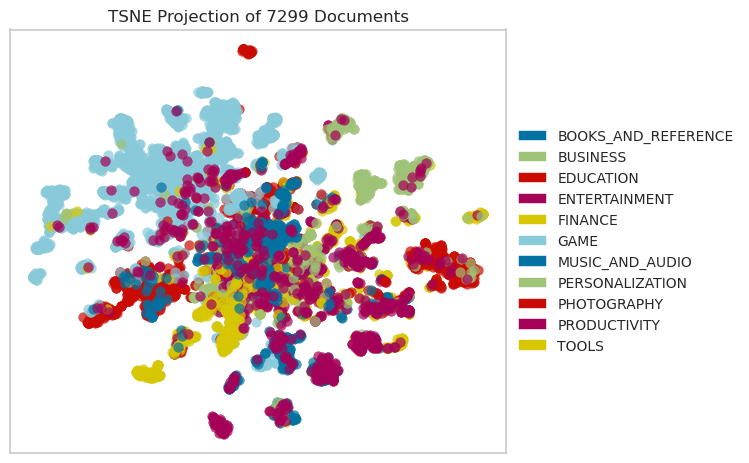

<AxesSubplot:title={'center':'TSNE Projection of 7299 Documents'}>

In [ ]:
# load Tfidf
tfidf = TfidfVectorizer()

# transform data
X = tfidf.fit_transform(aux.description)
y = aux.category

# build visualization
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

In [1]:
# Load data
import os, sys
sys.path.append('../src')
sys.path.append('../models')
from load_data import DataGetter
import pandas as pd

In [92]:
data_getter = DataGetter(['actual_set','app_installs','app_metadata',
                          'app_usage','validation_data'])
actual_set_df = data_getter.actual_set_df
app_installs_df = data_getter.app_installs_df
app_metadata_df = data_getter.app_metadata_df
app_usage_df = data_getter.app_usage_df
validation_set_df = data_getter.validation_set_df

In [95]:
app_installs_df

,uid,item_id,status,install_date
0,64190,593676,uninstalled,2022-07-01
1,45556,593676,uninstalled,2022-05-21
2,49642,601235,uninstalled,2022-07-07
3,1773,601235,uninstalled,2022-07-23
4,163462,601235,uninstalled,2022-04-18
...,...,...,...,...
3767264,257363,902907,uninstalled,2022-07-20
3767265,267842,902907,uninstalled,2022-05-15
3767266,200614,902907,uninstalled,2022-05-15
3767267,250849,902907,uninstalled,2022-04-25


In [19]:
aux = validation_set_df.copy()

In [3]:
data_getter = DataGetter(['app_metadata'], data_form='process')

In [4]:
data_in = data_getter.app_metadata_df

In [5]:
from content_base_filters import baseline_TFIDF

In [6]:
tf = baseline_TFIDF(4)

In [17]:
simil = tf.similiarities.copy()

In [12]:
from build_base_dataframes import apps_by_user, final_dataframe

In [13]:
apps = apps_by_user()
final_df = final_dataframe(4)

In [14]:
topk_for_each_app_installed = {}
for uid,row in aux.iterrows():
    user_id, items_id = uid, row.item_id
    topk_for_each_app_installed[user_id] = {}
    for item_id in items_id:
        try:
            topk_for_each_app_installed[user_id][item_id] = tf.get_topk_recomendations(str(item_id))
        except:
            pass

NameError: name 'aux' is not defined

In [15]:
def get_top10(data: pd.DataFrame, topkapps: dict) -> dict:
    for app_id in a.columns:
        topkapps[app_id] = a.nlargest(11,app_id)[1:11][app_id]
    return(topkapps)

In [16]:
import pandas as pd
import pickle

In [17]:
import numpy as np
from tqdm import tqdm
aux = df.copy()

NameError: name 'df' is not defined

In [10]:
simil = {}
for column in tqdm(aux.columns):
    simil[column] = aux[column].nlargest(10).iloc[1:10]

100%|██████████| 1174/1174 [00:13<00:00, 88.35it/s]


In [3]:
import pandas as pd
store = pd.HDFStore('exemplo.h5')

In [ ]:
aux.sort_values(by=aux.columns)

KeyError: Int64Index([593676, 601235, 860079,  64855, 597756, 824740,  64866, 930055,
            860078, 799720,
            ...
            895346, 865619, 749346, 904729, 781868, 741991, 861012, 783332,
            923787, 850552],
           dtype='int64', name='item_id', length=1000)

In [9]:
df = store.get('val_final')

In [11]:
store.close()

In [58]:
import pickle
with open('../data/final/similiarities.p', 'rb') as fp:
    similiarities = pickle.load(fp)
with open('../data/final/topk.p', 'rb') as fp:
    topk = pickle.load(fp)

In [ ]:
list(similiarities[593676].iloc[0:4].index)

[147711, 159178, 160499, 147741]

In [20]:
df = DataGetter(['validation_data'],data_form='raw').validation_set_df

In [18]:
from build_base_dataframes import apps_by_user, final_dataframe

In [359]:
t = apps_by_user()

In [361]:
t.loc[290183]

item_id    [145569, 145082, 25349, 820736, 150915]
Name: 290183, dtype: object

In [364]:
app_metadata_df[app_metadata_df['item_id'] == '605515']

,item_id,category,description
39107,605515,SOCIAL,"This app is not sponsored or endorsed by, or a..."


In [214]:
d_final = final_dataframe(4)

In [93]:
app_installs = DataGetter(['app_installs'], data_form='raw').app_installs_df

In [174]:
d_final.uid = d_final.uid.astype(int)

In [251]:
a = set(app_installs['uid'].values)
b = set(df['uid'].values)

[x for x in b if x not in a]

[]

In [32]:
import numpy as np
datagetter = DataGetter(['validation_data'], data_form='raw')
validation_df = datagetter.validation_set_df

base_df = pd.DataFrame(np.repeat(validation_df.values, 4, axis=0),
                                    columns=validation_df.columns)

base_df['item_id'] = np.zeros(base_df.shape[0])
base_df['uid'] = base_df['uid'].astype(int)

In [50]:
validation_df

,uid
0,255352
1,290183
2,210428
3,17401
4,48078
...,...
42247,125200
42248,134840
42249,132677
42250,244542


In [57]:
validation_df

,uid
0,255352
1,290183
2,210428
3,17401
4,48078
...,...
42247,125200
42248,134840
42249,132677
42250,244542


In [ ]:
import pickle
with open('../data/final/similiarities.p', 'rb') as fp:
    similiarities = pickle.load(fp)
with open('../data/final/topk.p', 'rb') as fp:
    topk = pickle.load(fp)

In [59]:
tfidf_base_pred = {}
for index,row in validation_df.iterrows():
    try:
        if len(topk[row.uid]) == 0:
            tfidf_base_pred[row.uid] = [25349, 55857, 20875, 145569]
        else:
            tfidf_base_pred[row.uid] = topk[row.uid]
    except KeyError:
        # recommend top apps
        tfidf_base_pred[row.uid] = [25349, 55857, 20875, 145569]

In [68]:
pd.DataFrame(tfidf_base_pred).melt(value_name='item_id', var_name='user_id')

,user_id,item_id
0,255352,25349
1,255352,55857
2,255352,20875
3,255352,145569
4,290183,605515
...,...,...
169003,244542,145569
169004,215598,604012
169005,215598,588071
169006,215598,143787


In [335]:
recommendations['uid'] = base_df['uid'].values

In [341]:
final = recommendations[['uid','item_id']].copy()

In [357]:
final.to_csv('../predictions/baseline_tfidf.csv', index=False)

In [356]:
app_metadata_df[app_metadata_df.item_id == '68476']

,item_id,category,description
24542,68476,ENTERTAINMENT,Brace yourself for Rama Raju &amp; Komaram Bhe...


In [104]:
apps_installed_by_user = (app_installs_df[app_installs_df.status == 'installed']
.groupby(by='uid')['item_id']
.apply(list)
.reset_index(name='item_id'))

In [150]:
def topk_similiars(app_id : str):
        """ Returns top k similars apps of app_id."""
        try:
                topk = similiarities[app_id].iloc[0:4]
        except KeyError:
                return(0)
        return(topk)

In [157]:
def topk_apps(apps_of_user):
    """ Return top k apps most similars with all apps in user mobile."""
    topk_apps = pd.DataFrame()
    for app in apps_of_user:
        similars = topk_similiars(app)
        if type(similars) == int:
            continue
        else:
            topk_apps = pd.concat([topk_apps, similars])
    if topk_apps.shape[0] == 0:
        return(topk_apps)
    return(list(topk_apps.nlargest(4, columns=0).index))

In [158]:
def test(df_a):
    topk_apps_for_user = {}
    for _, row in df_a.iterrows():
        topk_apps_for_user[row.uid] = topk_apps(row.item_id)
    return(topk_apps_for_user)

In [159]:
df_a = apps_installed_by_user.iloc[0:100]
topk = test(df_a)

In [160]:
topk

{3: [587532, 816793, 588680, 879314],
 7: [841604, 158786, 797868, 827553],
 10: [163480, 149234, 66659, 137541],
 12: [612457, 601125, 596914, 861102],
 13: [817273, 150579, 744285, 841604],
 14: [831279, 922085, 857836, 163436],
 15: [612457, 928704, 841604, 152977],
 17: [858640, 599633, 6941, 928768],
 18: [906461, 611233, 858351, 843830],
 20: [868558, 821508, 153797, 844716],
 25: [612457, 859715, 838627, 159776],
 26: [612457, 821631, 821630, 859566],
 28: Empty DataFrame
 Columns: []
 Index: [],
 31: [889722, 872184, 689816, 612688],
 35: [661682, 878794, 588656, 823571],
 36: [612457, 928638, 116973, 836608],
 37: [845082, 159830, 161569, 159828],
 44: [830005, 607035, 153184, 876128],
 46: [601411, 152962, 837221, 817036],
 50: [889416, 685698, 689816, 591100],
 52: [906461, 611233, 858351, 843830],
 58: [822905, 887154, 678719, 833503],
 65: [770574, 599633, 6941, 819015],
 69: [612457, 841604, 678971, 885087],
 70: [817040, 150651, 861474, 860215],
 71: [868476, 154134, 589

In [143]:
topk

{3: [587532, 816793, 588680, 879314],
 7: [587532, 816793, 588680, 879314],
 10: [587532, 816793, 588680, 879314],
 12: [587532, 816793, 588680, 879314],
 13: [587532, 816793, 588680, 879314],
 14: [587532, 816793, 588680, 879314],
 15: [587532, 816793, 588680, 879314],
 17: [587532, 816793, 588680, 879314],
 18: [587532, 816793, 588680, 879314],
 20: [587532, 816793, 588680, 879314],
 25: [587532, 816793, 588680, 879314],
 26: [587532, 816793, 588680, 879314],
 28: [587532, 816793, 588680, 879314],
 31: [587532, 816793, 588680, 879314],
 35: [587532, 816793, 588680, 879314],
 36: [587532, 816793, 588680, 879314],
 37: [587532, 816793, 588680, 879314],
 44: [587532, 816793, 588680, 879314],
 46: [587532, 816793, 588680, 879314],
 50: [587532, 816793, 588680, 879314],
 52: [587532, 816793, 588680, 879314],
 58: [587532, 816793, 588680, 879314],
 65: [587532, 816793, 588680, 879314],
 69: [587532, 816793, 588680, 879314],
 70: [587532, 816793, 588680, 879314],
 71: [587532, 816793, 58868

In [32]:
from load_data import DataGetter

In [38]:
app_metadata_df = DataGetter(['app_metadata'], data_form='raw').app_metadata_df
actual_set_df = DataGetter(['actual_set'], data_form='raw').actual_set_df

In [42]:
app_metadata_df[app_metadata_df.item_id == '928550']

,item_id,category,description
726,928550,GAME,"बबल शूट, क्लासिक शूटर बबल गेम हैं, आपको सभी बब..."


In [71]:
topk

{3: [587532, 816793, 588680, 879314],
 7: [158786, 797868, 827553, 588289],
 10: [163480, 149234, 66659, 137541],
 12: [839178, 749981, 608556, 728420],
 13: [841604, 150706, 144786, 844716],
 14: [831279, 922085, 857836, 163436],
 15: [605515, 157025, 878794, 77746],
 17: [605515, 157025, 878794, 77746],
 18: [605515, 157025, 878794, 77746],
 20: [868558, 821508, 153797, 844716],
 25: [612457, 830272, 143949, 898921],
 26: [612457, 830272, 143949, 898921],
 28: Empty DataFrame
 Columns: []
 Index: [],
 31: [889722, 872184, 689816, 612688],
 35: [661682, 878794, 588656, 823571],
 36: [605515, 157025, 878794, 77746],
 37: [154833, 154700, 68901, 601327],
 44: [891136, 588932, 837221, 152962],
 46: [601411, 152962, 837221, 850926],
 50: [889416, 685698, 689816, 591100],
 52: [605515, 157025, 878794, 77746],
 58: [599633, 6941, 928768, 785749],
 65: [770574, 819015, 595083, 819107],
 69: [599633, 6941, 928768, 785749],
 70: [817040, 150651, 861474, 860215],
 71: [891136, 588932, 837221, 1

In [37]:
app_metadata_df[app_metadata_df.item_id == 928550]

,item_id,category,description


In [ ]:
a = pd.concat([top, topk_similiars(150706)])

In [ ]:
b = pd.concat([a, topk_similiars(841604)])

In [ ]:
b.nlargest(4,columns=0).index

Int64Index([841604, 150706, 7400, 7400], dtype='int64')

In [ ]:
topk_similiars(150706)

item_id
841604    0.917260
7400      0.725215
158617    0.708685
821508    0.703519
Name: 150706, dtype: float64

In [ ]:
from tqdm import tqdm
def test():
    similiarities = {}
    for key in tqdm(store.keys()):
        df = store.get(key=key)
        for app_id, column in df.iterrows():
            similiarities[app_id] = column.nlargest(11).iloc[1:10]
        return(similiarities)

In [ ]:
test()

  0%|          | 0/48 [00:05<?, ?it/s]


{593676: item_id
 165443    0.468949
 588685    0.450841
 721376    0.365507
 604980    0.340697
 65582     0.264653
 834619    0.260837
 65459     0.103768
 626511    0.103182
 915357    0.100343
 Name: 593676, dtype: float64}

In [ ]:
df = store.get('val_1')
for app_id, column in df.items():
        similiarities[app_id] = column.nlargest(11).iloc[1:10]

In [ ]:
for app_id, column in df.items():
        similiarities[app_id] = column.nlargest(11).iloc[1:10]
        break

In [ ]:
for index, row in df.iterrows():
    print(row.nlargest(11).iloc[0:10])
    print(index)
    break

item_id
593676    1.000000
165443    0.468949
588685    0.450841
721376    0.365507
604980    0.340697
65582     0.264653
834619    0.260837
65459     0.103768
626511    0.103182
915357    0.100343
Name: 593676, dtype: float64
593676


In [225]:
import pickle
with open('../data/final/topk.p', 'wb') as handle:
    pickle.dump(topk, handle, protocol=pickle.HIGHEST_PROTOCOL)